In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler as srs
import random
import matplotlib.pyplot as plt
from collections import Counter
import torch.optim as optim
use_cuda = True
import time
from torch.utils.data import DataLoader


In [10]:
dir = '/Users/endothermiic/Desktop/GitHub/APS360_Project/aps360dataset'
transform = transforms.Compose([transforms.ToTensor(),
         transforms.Resize((224, 224)), # images are either 450 * 600 or 1024 * 1024
                                # all resized to 224 * 224 for ResNet
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# transform input images to match requirements; load all images to all_data
all_data = torchvision.datasets.ImageFolder(dir, transform=transform)

In [11]:
all_data

Dataset ImageFolder
    Number of datapoints: 23344
    Root location: /Users/endothermiic/Desktop/GitHub/APS360_Project/aps360dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [52]:
# use a set, random seed
torch.manual_seed(0)

# find 20% of len(all_data) for 20% test and val sets
test_size = int(len(all_data) * 0.04)

# remaining ~60% is left for training
train_size = int(len(all_data) * 0.12)

extra = len(all_data) - 2 * test_size - train_size

In [53]:
# randomly split the data into training, test and validation sets
train_data, val_data, test_data, extra = torch.utils.data.random_split(all_data,
  [train_size, test_size, test_size, extra])

# use Dataloader to allow for iteration (img, label) over a dataset
# same method used in previous labs
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True)

print("There are {0} images in training, ".format(len(train_loader)))
print("{0} images in validation and ".format(len(val_loader)))
print("{0} images in testing".format(len(test_loader)))

There are 2801 images in training, 
933 images in validation and 
933 images in testing


In [56]:
def get_counts(loader):
    # information from dataloader
    labels = [label for img, label in loader.dataset]

    # num / class counted
    counts = dict(Counter(labels))

    return counts

train_counts = get_counts(train_loader)
val_counts = get_counts(val_loader)
test_counts = get_counts(test_loader)

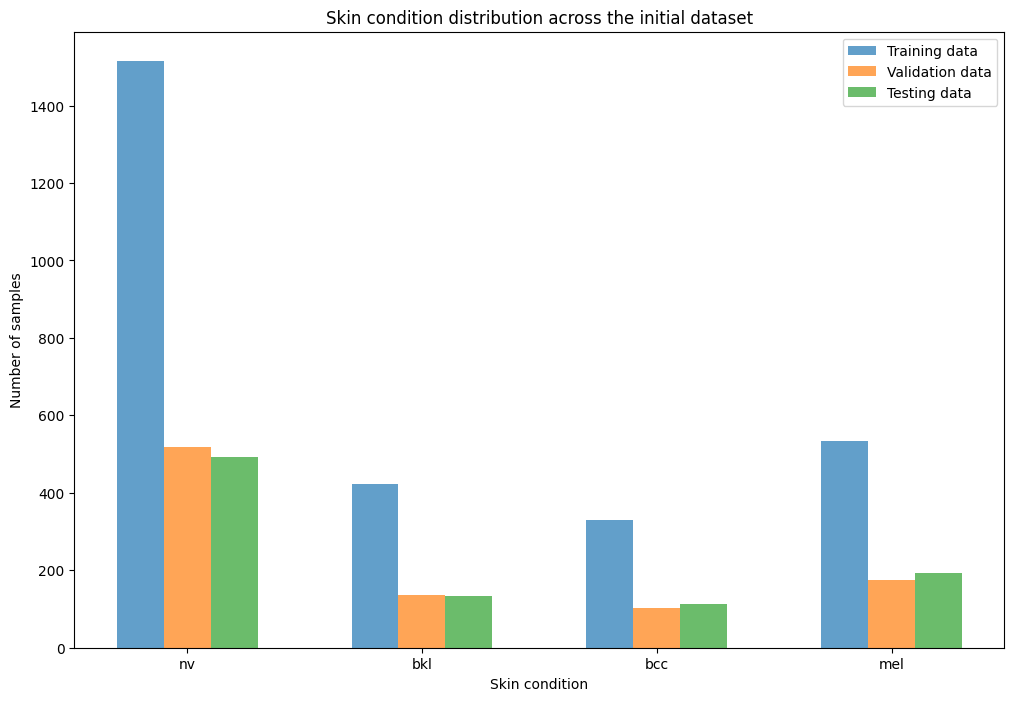

In [57]:
# Pre data augmentation 
labels = ['nv', 'bkl', 'bcc', 'mel']

def plot(train_counts, val_counts, test_counts, title):
    conditions = train_counts.keys()

    train_values = [train_counts.get(c, 0) for c in conditions]
    val_values = [val_counts.get(c, 0) for c in conditions]
    test_values = [test_counts.get(c, 0) for c in conditions]
    
    x = np.arange(len(conditions))
    width = 0.2 
    
    plt.figure(figsize=(12, 8))
    plt.bar(x - width, train_values, width, label='Training data', alpha=0.7)
    plt.bar(x, val_values, width, label='Validation data', alpha=0.7)
    plt.bar(x + width, test_values, width, label='Testing data', alpha=0.7)
    
    plt.xlabel('Skin condition')
    plt.ylabel('Number of samples')
    plt.title(title)
    plt.xticks(x, labels) # can confirm with swapping out conditions here
    plt.legend()
    
    plt.show()


plot(train_counts, val_counts, test_counts, "Skin condition distribution across the initial dataset")


In [58]:
conditions = train_counts.keys()
t_counts = [train_counts.get(c, 0) for c in conditions]
print(f"Training counts: {t_counts}")
v_counts = [val_counts.get(c, 0) for c in conditions]
print(f"Val counts: {v_counts}")
te_counts = [test_counts.get(c, 0) for c in conditions]
print(f"Test counts: {te_counts}")

Training counts: [1515, 423, 329, 534]
Val counts: [519, 137, 102, 175]
Test counts: [493, 133, 113, 194]


In [59]:
def augment(data, counts):
    max_count = max(counts)
    augments = [max_count - c for c in counts]

    # transforms for augmentation
    horiz = transforms.RandomHorizontalFlip()
    vert = transforms.RandomVerticalFlip()
    rot = transforms.RandomRotation(90)
    rot_1 = transforms.RandomRotation(270)

    
    augmented_data = []
    all_images = {i: [] for i in range(0, 3)}

    for img, label in data: 
        if label in range(0,3): # minority classes have labels 0, 1, 2
            all_images[label].append((img, label))

    for i in range(0, 3):
        images = all_images[i]
        
        for img, label in images:
            if augments[i + 1] <= 5: # initial class is majority class
                break
            augmented_data.append((horiz(img), label))
            augmented_data.append((vert(img), label))
            augmented_data.append((rot(img), label)) 
            augmented_data.append((rot_1(img), label))
            augments[i + 1] -= 4
            counts[i + 1] += 4
    
    full = data + augmented_data
    return full, counts

In [60]:
aug_test, test_counts = augment(test_data, te_counts)
aug_val, val_counts = augment(val_data, v_counts)
aug_train, train_counts = augment(train_data, t_counts)

In [61]:
train_loader = torch.utils.data.DataLoader(aug_train, shuffle=True)
val_loader = torch.utils.data.DataLoader(aug_val, shuffle=True)
test_loader = torch.utils.data.DataLoader(aug_test, shuffle=True)

In [62]:
# convert list to dict for visualization
def list_to_dict(counts):
    return {0: counts[1], 1: counts[2], 2: counts[3], 3: counts[0]}

test_dict = list_to_dict(test_counts)
val_dict = list_to_dict(val_counts)
train_dict = list_to_dict(train_counts)

In [75]:
train_counts_1 = get_counts(train_loader) # can confirm results with counter
val_counts_1 = get_counts(val_loader)
test_counts_1 = get_counts(test_loader)

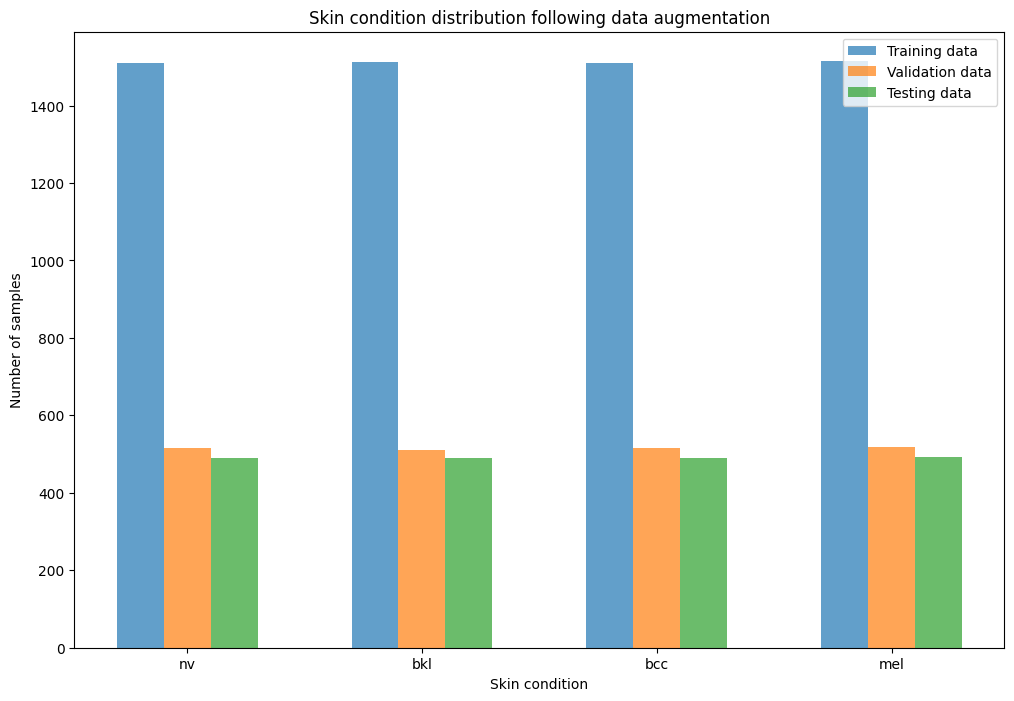

In [63]:
plot(train_dict, val_dict, test_dict, "Skin condition distribution following data augmentation")

# Model

In [37]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [34]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.name = "cnn"
        # Input shape [128, 512, 7, 7] == [batch size, channels, feature map width, fm height]
        self.conv1 = nn.Conv2d(512, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.cbam1 = CBAM(128)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cbam2 = CBAM(64)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.cbam3 = CBAM(32)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(32 * 7 * 7, 4)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.cbam1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.cbam2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.cbam3(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [46]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)


train_features, val_features, test_features = [], [], []

# Remove the final fully connected layer
model = nn.Sequential(*list(model.children())[:-2])
model.eval()  # Set model to evaluation mode

def get_features(loader, save):
    for imgs, labels in loader:
        with torch.no_grad():
            features = model(imgs)  # Shape: [batch_size, 512, 7, 7]
        save.append([features, labels])

# Example usage with train_loader, val_loader, test_loader
get_features(train_loader, train_features)
get_features(val_loader, val_features)
get_features(test_loader, test_features)


Using cache found in /Users/endothermiic/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature, label = self.features[idx]
        return feature.squeeze(), label

train_dataset = FeatureDataset(train_features)
val_dataset = FeatureDataset(val_features)
test_dataset = FeatureDataset(test_features)

In [19]:
def get_accuracy(model, data, batch_size):
    correct = 0
    total = 0

    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1,keepdim = True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [41]:
def train(model, data, val_data=None, trial_num=0, batch_size=1, lr=0.01, num_epochs=10):
    torch.manual_seed(1000)

    if use_cuda and torch.cuda.is_available():
        model.cuda()

    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)

    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    start_time = time.time()

    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in data_loader:
            #print(imgs.shape)
            #print(labels)
            #print("Image shape before: ", imgs.shape)
            #imgs = imgs.squeeze(0)
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            labels = labels.squeeze()

            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

        for imgs, labels in val_loader:
            #print(imgs.shape)
            #print(labels)
            #print("Image shape before: ", imgs.shape)
            #imgs = imgs.squeeze(0)
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            labels = labels.squeeze()

            out = model(imgs)             # forward pass
            v_loss = criterion(out, labels) # compute the total loss


        # save the current training information
        iters.append(n)
        train_loss.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, data, batch_size=batch_size)) # compute training accuracy


        val_acc.append(get_accuracy(model, val_data, batch_size=batch_size))  # compute validation accuracy
        val_loss.append(float(v_loss)/batch_size)
        n += 1


        if val_data != None:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]} | Validation acc: {val_acc[-1]}")
        else:
            print(f"Epoch {epoch + 1}: Train acc: {train_acc[-1]}")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} s")

    # plot
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    if val_data != None:
        print("Final Validation Accuracy: {}".format(val_acc[-1]))

## 3500 imags, imbalanced

Epoch 1: Train acc: 0.5449871465295629 | Validation acc: 0.5312767780634104
Epoch 2: Train acc: 0.5886889460154242 | Validation acc: 0.5664095972579263
Epoch 3: Train acc: 0.6386746643816053 | Validation acc: 0.5989717223650386
Epoch 4: Train acc: 0.6818051985147101 | Validation acc: 0.6461011139674379
Epoch 5: Train acc: 0.7023707512139389 | Validation acc: 0.6486718080548415
Epoch 6: Train acc: 0.731505284204513 | Validation acc: 0.6700942587832048
Epoch 7: Train acc: 0.7435018566123964 | Validation acc: 0.6486718080548415
Epoch 8: Train acc: 0.7757783490431306 | Validation acc: 0.6700942587832048
Epoch 9: Train acc: 0.8046272493573264 | Validation acc: 0.676949443016281
Epoch 10: Train acc: 0.8400457012282205 | Validation acc: 0.6700942587832048
Epoch 11: Train acc: 0.8708940302770637 | Validation acc: 0.6889460154241646
Epoch 12: Train acc: 0.8837475007140817 | Validation acc: 0.6743787489288775
Epoch 13: Train acc: 0.9200228506141103 | Validation acc: 0.6786632390745502
Epoch 14: 

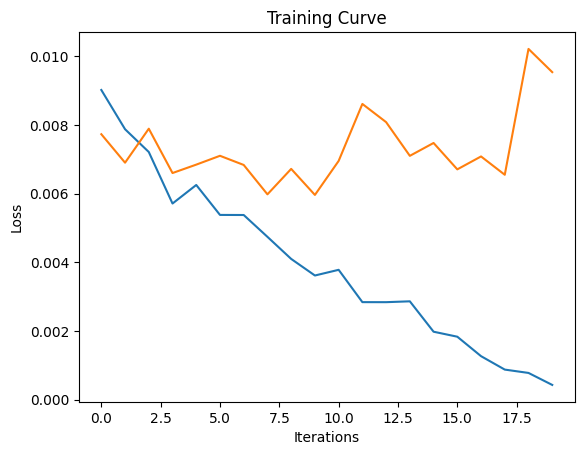

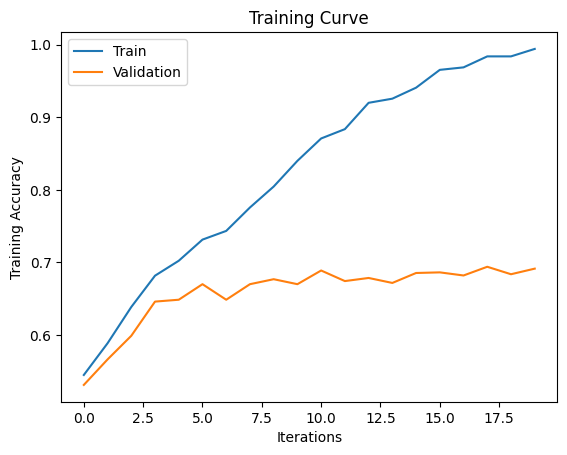

Final Training Accuracy: 0.9942873464724364
Final Validation Accuracy: 0.6915167095115681


In [26]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=128, lr=0.001, num_epochs=20)

Epoch 1: Train acc: 0.5287060839760068 | Validation acc: 0.5261353898886033
Epoch 2: Train acc: 0.5478434732933447 | Validation acc: 0.5278491859468724
Epoch 3: Train acc: 0.548129105969723 | Validation acc: 0.5338474721508141
Epoch 4: Train acc: 0.5478434732933447 | Validation acc: 0.5389888603256212
Epoch 5: Train acc: 0.5506998000571265 | Validation acc: 0.5389888603256212
Epoch 6: Train acc: 0.5541273921736647 | Validation acc: 0.5355612682090831
Epoch 7: Train acc: 0.5615538417594973 | Validation acc: 0.5484147386461011
Epoch 8: Train acc: 0.5686946586689517 | Validation acc: 0.5484147386461011
Epoch 9: Train acc: 0.5801199657240789 | Validation acc: 0.5552699228791774
Epoch 10: Train acc: 0.5904027420736933 | Validation acc: 0.5689802913453299
Epoch 11: Train acc: 0.609254498714653 | Validation acc: 0.5938303341902313
Epoch 12: Train acc: 0.6218223364752927 | Validation acc: 0.5955441302485004
Epoch 13: Train acc: 0.6326763781776635 | Validation acc: 0.6083976006855184
Epoch 14: 

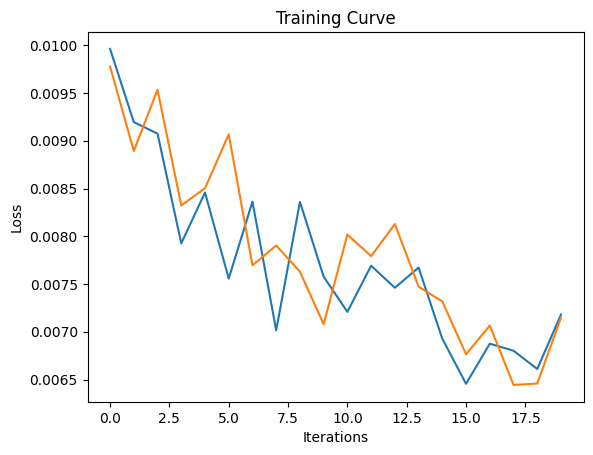

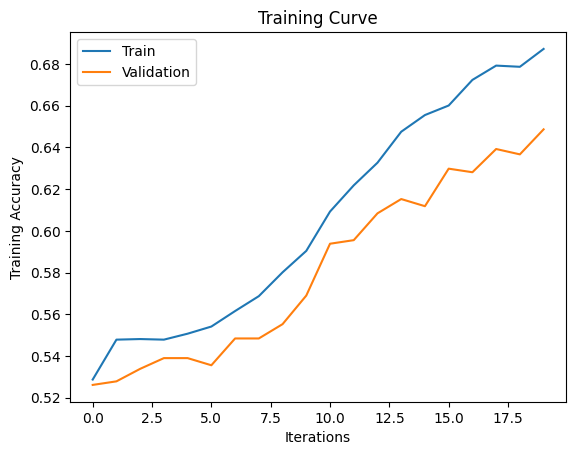

Final Training Accuracy: 0.6872322193658955
Final Validation Accuracy: 0.6486718080548415


In [27]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=128, lr=0.0001, num_epochs=20)

Epoch 1: Train acc: 0.6338189088831763 | Validation acc: 0.6015424164524421
Epoch 2: Train acc: 0.6966580976863753 | Validation acc: 0.6401028277634961
Epoch 3: Train acc: 0.7257926306769494 | Validation acc: 0.6443873179091688
Epoch 4: Train acc: 0.7563553270494144 | Validation acc: 0.662382176520994
Epoch 5: Train acc: 0.7709225935447015 | Validation acc: 0.6495287060839761
Epoch 6: Train acc: 0.8274778634675807 | Validation acc: 0.6589545844044559
Epoch 7: Train acc: 0.8477577834904313 | Validation acc: 0.6418166238217652
Epoch 8: Train acc: 0.8660382747786347 | Validation acc: 0.6461011139674379
Epoch 9: Train acc: 0.8997429305912596 | Validation acc: 0.6700942587832048
Epoch 10: Train acc: 0.9154527277920594 | Validation acc: 0.6632390745501285
Total time elapsed: 86.49 s


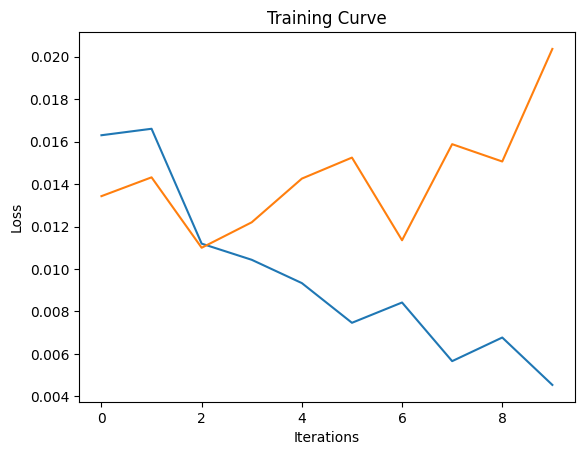

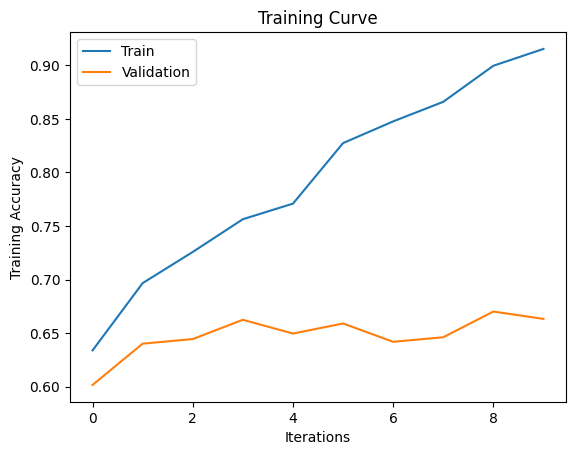

Final Training Accuracy: 0.9154527277920594
Final Validation Accuracy: 0.6632390745501285


In [28]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=64, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.5467009425878321 | Validation acc: 0.5287060839760068
Epoch 2: Train acc: 0.5484147386461011 | Validation acc: 0.5304198800342759
Epoch 3: Train acc: 0.5558411882319337 | Validation acc: 0.5398457583547558
Epoch 4: Train acc: 0.5632676378177663 | Validation acc: 0.5492716366752356
Epoch 5: Train acc: 0.5912596401028277 | Validation acc: 0.5621251071122536
Epoch 6: Train acc: 0.614110254213082 | Validation acc: 0.586975149957155
Epoch 7: Train acc: 0.639817195087118 | Validation acc: 0.5904027420736933
Epoch 8: Train acc: 0.6489574407312196 | Validation acc: 0.6058269065981148
Epoch 9: Train acc: 0.6629534418737504 | Validation acc: 0.6135389888603257
Epoch 10: Train acc: 0.6669522993430449 | Validation acc: 0.6118251928020566
Total time elapsed: 93.19 s


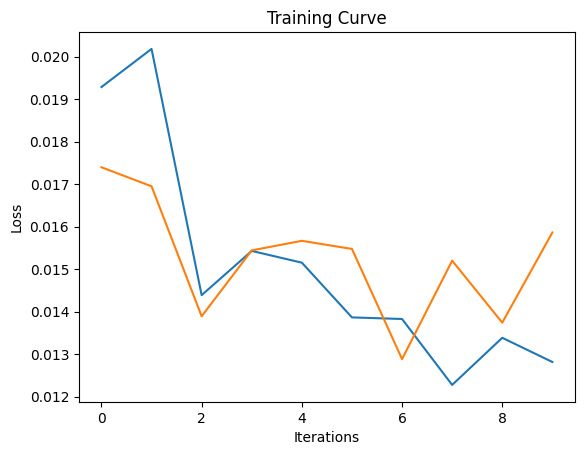

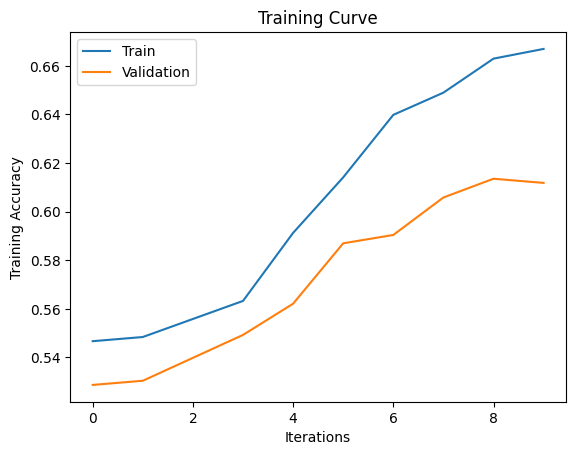

Final Training Accuracy: 0.6669522993430449
Final Validation Accuracy: 0.6118251928020566


In [29]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=10)

In [30]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=64, lr=0.0004, num_epochs=50)

Epoch 1: Train acc: 0.554698657526421 | Validation acc: 0.5398457583547558
Epoch 2: Train acc: 0.6155384175949729 | Validation acc: 0.5861182519280206
Epoch 3: Train acc: 0.6755212796343901 | Validation acc: 0.6246786632390745
Epoch 4: Train acc: 0.6986575264210225 | Validation acc: 0.6580976863753213
Epoch 5: Train acc: 0.7160811196800914 | Validation acc: 0.6640959725792631
Epoch 6: Train acc: 0.7329334475864039 | Validation acc: 0.6692373607540703
Epoch 7: Train acc: 0.7495001428163381 | Validation acc: 0.6675235646958012
Epoch 8: Train acc: 0.7714938588974579 | Validation acc: 0.6632390745501285
Epoch 9: Train acc: 0.7946301056840903 | Validation acc: 0.6649528706083976
Epoch 10: Train acc: 0.808626106826621 | Validation acc: 0.6615252784918595
Epoch 11: Train acc: 0.821479577263639 | Validation acc: 0.6598114824335904
Epoch 12: Train acc: 0.8577549271636675 | Validation acc: 0.6649528706083976
Epoch 13: Train acc: 0.8757497857754927 | Validation acc: 0.6632390745501285
Epoch 14: T

KeyboardInterrupt: 

Epoch 1: Train acc: 0.5518423307626392 | Validation acc: 0.5389888603256212
Epoch 2: Train acc: 0.56583833190517 | Validation acc: 0.5389888603256212
Epoch 3: Train acc: 0.5812624964295915 | Validation acc: 0.5604113110539846
Epoch 4: Train acc: 0.5892602113681805 | Validation acc: 0.5732647814910026
Epoch 5: Train acc: 0.6072550699800057 | Validation acc: 0.5715509854327335
Epoch 6: Train acc: 0.6212510711225364 | Validation acc: 0.586975149957155
Epoch 7: Train acc: 0.6392459297343616 | Validation acc: 0.6023993144815767
Epoch 8: Train acc: 0.6523850328477577 | Validation acc: 0.6203941730934018
Epoch 9: Train acc: 0.6698086261068266 | Validation acc: 0.6178234790059983
Epoch 10: Train acc: 0.6923736075407027 | Validation acc: 0.6323907455012854
Total time elapsed: 115.18 s


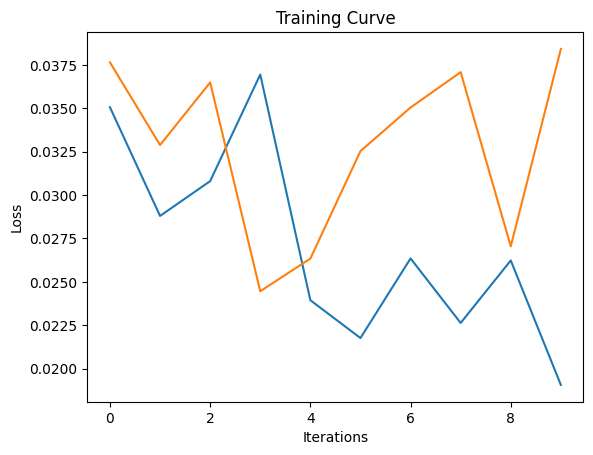

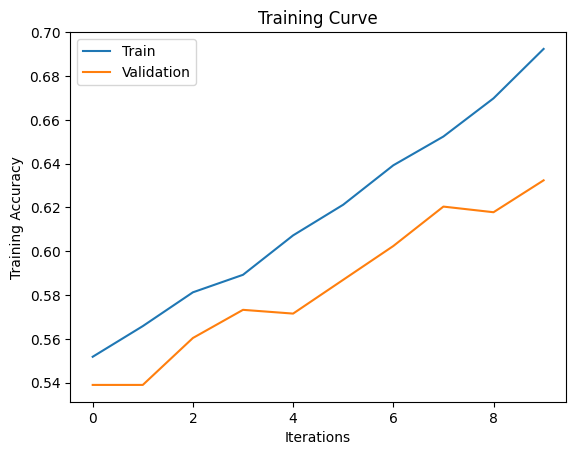

Final Training Accuracy: 0.6923736075407027
Final Validation Accuracy: 0.6323907455012854


In [32]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=32, lr=0.0001, num_epochs=10)

In [33]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=16, lr=0.0001, num_epochs=40)

Epoch 1: Train acc: 0.5452727792059412 | Validation acc: 0.5329905741216795
Epoch 2: Train acc: 0.598114824335904 | Validation acc: 0.585261353898886
Epoch 3: Train acc: 0.6600971151099686 | Validation acc: 0.6358183376178235
Epoch 4: Train acc: 0.6795201371036846 | Validation acc: 0.6426735218508998
Epoch 5: Train acc: 0.7080834047415024 | Validation acc: 0.6520994001713796
Epoch 6: Train acc: 0.7249357326478149 | Validation acc: 0.6520994001713796
Epoch 7: Train acc: 0.7489288774635818 | Validation acc: 0.662382176520994
Epoch 8: Train acc: 0.7743501856612397 | Validation acc: 0.6700942587832048
Epoch 9: Train acc: 0.7917737789203085 | Validation acc: 0.6606683804627249
Epoch 10: Train acc: 0.8226221079691517 | Validation acc: 0.6658097686375322
Epoch 11: Train acc: 0.8449014567266495 | Validation acc: 0.6692373607540703
Epoch 12: Train acc: 0.8723221936589546 | Validation acc: 0.6563838903170522
Epoch 13: Train acc: 0.8863181948014853 | Validation acc: 0.6563838903170522
Epoch 14: T

KeyboardInterrupt: 

Epoch 1: Train acc: 0.6069694373036275 | Validation acc: 0.5698371893744645
Epoch 2: Train acc: 0.689802913453299 | Validation acc: 0.6435304198800342
Epoch 3: Train acc: 0.7280776920879749 | Validation acc: 0.6580976863753213
Epoch 4: Train acc: 0.7566409597257926 | Validation acc: 0.6649528706083976
Epoch 5: Train acc: 0.8031990859754355 | Validation acc: 0.6486718080548415
Epoch 6: Train acc: 0.8277634961439588 | Validation acc: 0.6580976863753213
Epoch 7: Train acc: 0.8346186803770351 | Validation acc: 0.6735218508997429
Epoch 8: Train acc: 0.8634675806912311 | Validation acc: 0.6572407883461868
Epoch 9: Train acc: 0.8863181948014853 | Validation acc: 0.6572407883461868
Epoch 10: Train acc: 0.9108826049700086 | Validation acc: 0.6529562982005142
Total time elapsed: 110.96 s


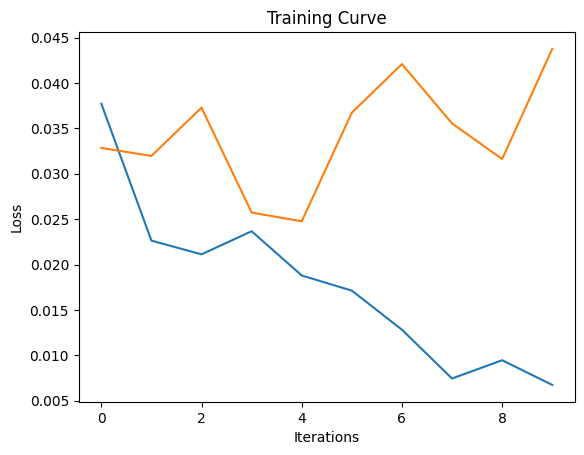

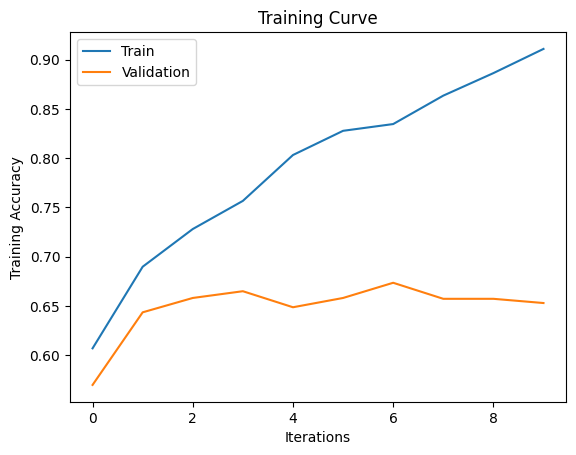

Final Training Accuracy: 0.9108826049700086
Final Validation Accuracy: 0.6529562982005142


In [42]:
model_cnn_1 = CNNClassifier()
train(model_cnn_1, train_dataset, val_dataset, batch_size=32, lr=0.001, num_epochs=10)

## 7000 images, imbalanced

Epoch 1: Train acc: 0.5730401256604313 | Validation acc: 0.5801199657240789
Epoch 2: Train acc: 0.6667142653148651 | Validation acc: 0.6692373607540703
Epoch 3: Train acc: 0.699557332571755 | Validation acc: 0.6782347900599829
Epoch 4: Train acc: 0.7288305012137656 | Validation acc: 0.6928020565552699
Epoch 5: Train acc: 0.7379694416678566 | Validation acc: 0.7060839760068551
Epoch 6: Train acc: 0.776952734542339 | Validation acc: 0.7065124250214224
Epoch 7: Train acc: 0.8030843924032558 | Validation acc: 0.7022279348757497
Epoch 8: Train acc: 0.8336427245466229 | Validation acc: 0.7086546700942588
Epoch 9: Train acc: 0.8526345851777809 | Validation acc: 0.7146529562982005
Epoch 10: Train acc: 0.87248322147651 | Validation acc: 0.7116538131962297
Total time elapsed: 185.68 s


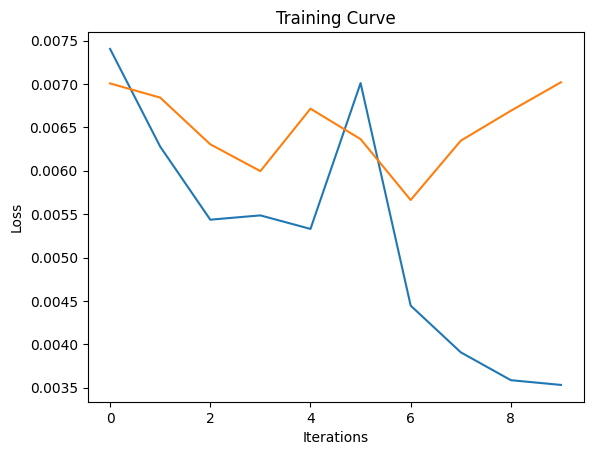

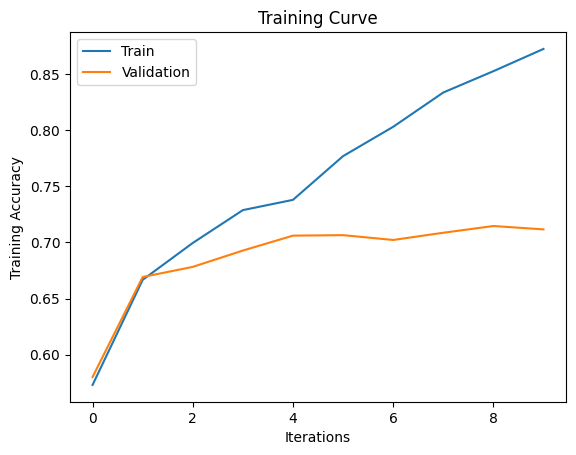

Final Training Accuracy: 0.87248322147651
Final Validation Accuracy: 0.7116538131962297


In [48]:
model_cnn_2 = CNNClassifier() # 7000 training images
train(model_cnn_2, train_dataset, val_dataset, batch_size=128, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.6701413679851492 | Validation acc: 0.6645244215938303
Epoch 2: Train acc: 0.7072683135798943 | Validation acc: 0.6803770351328192
Epoch 3: Train acc: 0.7488219334570898 | Validation acc: 0.6983718937446444
Epoch 4: Train acc: 0.7750963872626018 | Validation acc: 0.7103684661525278
Epoch 5: Train acc: 0.8033699842924461 | Validation acc: 0.7180805484147387
Epoch 6: Train acc: 0.8330715407682422 | Validation acc: 0.7069408740359897
Epoch 7: Train acc: 0.8653434242467514 | Validation acc: 0.7060839760068551
Epoch 8: Train acc: 0.8766243038697701 | Validation acc: 0.7030848329048843
Epoch 9: Train acc: 0.8994716550049978 | Validation acc: 0.7035132819194516
Epoch 10: Train acc: 0.9143224332428959 | Validation acc: 0.7043701799485861
Total time elapsed: 166.55 s


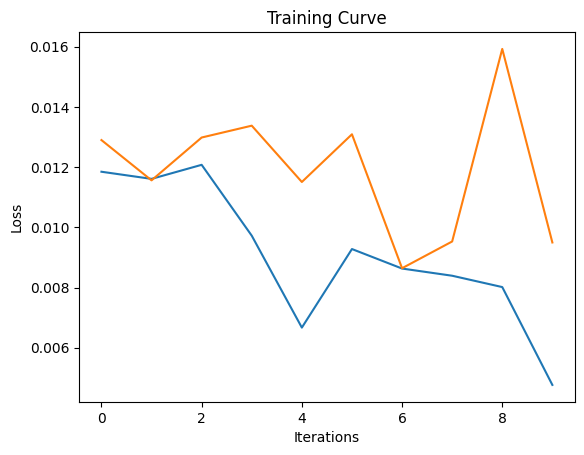

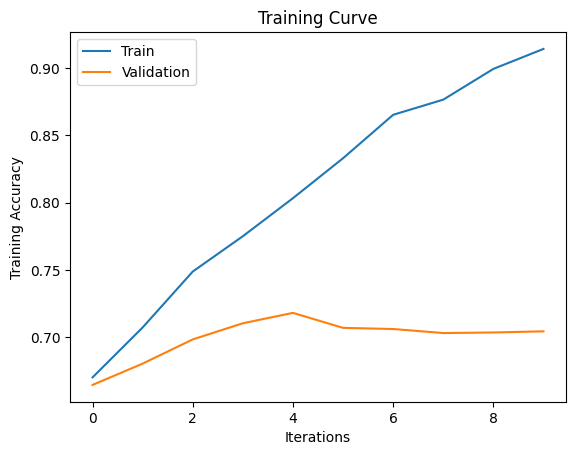

Final Training Accuracy: 0.9143224332428959
Final Validation Accuracy: 0.7043701799485861


In [49]:
model_cnn_2 = CNNClassifier() # 7000 training images
train(model_cnn_2, train_dataset, val_dataset, batch_size=64, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.5454805083535628 | Validation acc: 0.5574121679520138
Epoch 2: Train acc: 0.5471940596887048 | Validation acc: 0.5651242502142245
Epoch 3: Train acc: 0.5683278594887905 | Validation acc: 0.583547557840617
Epoch 4: Train acc: 0.5908896187348279 | Validation acc: 0.5976863753213367
Epoch 5: Train acc: 0.6118806225903184 | Validation acc: 0.6251071122536418
Epoch 6: Train acc: 0.6317292588890475 | Validation acc: 0.6383890317052271
Epoch 7: Train acc: 0.648579180351278 | Validation acc: 0.6628106255355612
Epoch 8: Train acc: 0.6597172640297015 | Validation acc: 0.6675235646958012
Epoch 9: Train acc: 0.6721405112094817 | Validation acc: 0.6795201371036846
Epoch 10: Train acc: 0.6825646151649293 | Validation acc: 0.6765209940017138
Total time elapsed: 183.05 s


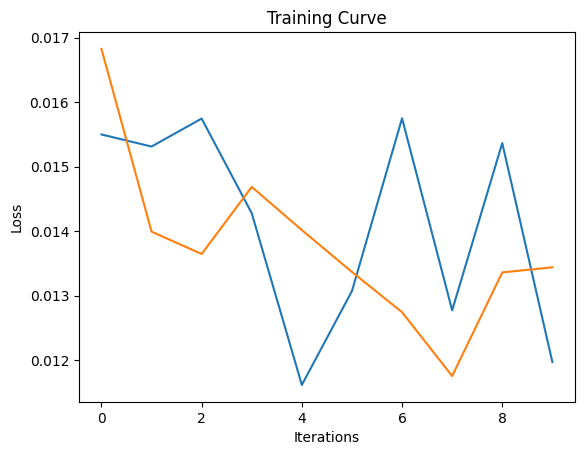

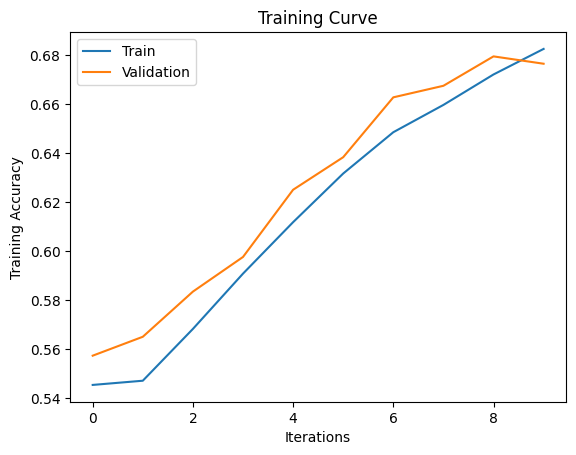

Final Training Accuracy: 0.6825646151649293
Final Validation Accuracy: 0.6765209940017138


In [51]:
model_cnn_2 = CNNClassifier() # 7000 training images
train(model_cnn_2, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=10)

## 7000, even split

Epoch 1: Train acc: 0.5424817935170642 | Validation acc: 0.5578406169665809
Epoch 2: Train acc: 0.5419106097386834 | Validation acc: 0.5599828620394173
Epoch 3: Train acc: 0.5439097529630158 | Validation acc: 0.5612682090831191
Epoch 4: Train acc: 0.5497643866914179 | Validation acc: 0.5655526992287918
Epoch 5: Train acc: 0.5617592460374126 | Validation acc: 0.5745501285347043
Epoch 6: Train acc: 0.583464229615879 | Validation acc: 0.6023993144815767
Epoch 7: Train acc: 0.5936027416821362 | Validation acc: 0.6036846615252784
Epoch 8: Train acc: 0.6141653577038412 | Validation acc: 0.62382176520994
Epoch 9: Train acc: 0.6293017278309296 | Validation acc: 0.6345329905741217
Epoch 10: Train acc: 0.6348707696701413 | Validation acc: 0.6448157669237361
Total time elapsed: 206.75 s


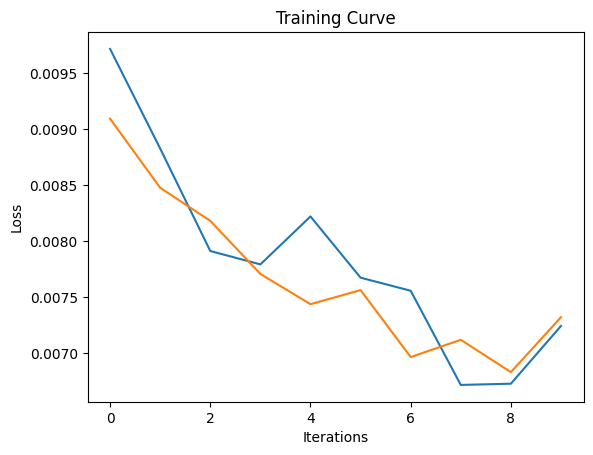

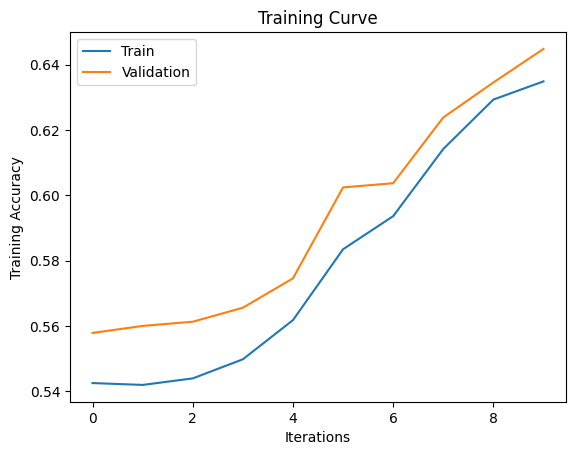

Final Training Accuracy: 0.6348707696701413
Final Validation Accuracy: 0.6448157669237361


In [64]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=128, lr=0.0001, num_epochs=10)

In [65]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=256, lr=0.001, num_epochs=20)

Epoch 1: Train acc: 0.5469084677995145 | Validation acc: 0.5638389031705227
Epoch 2: Train acc: 0.6273025846065972 | Validation acc: 0.6328191945158527
Epoch 3: Train acc: 0.6631443666999857 | Validation acc: 0.6666666666666666
Epoch 4: Train acc: 0.6862773097244038 | Validation acc: 0.6730934018851756
Epoch 5: Train acc: 0.7035556190204199 | Validation acc: 0.6842330762639246
Epoch 6: Train acc: 0.7135513351420819 | Validation acc: 0.6863753213367609
Epoch 7: Train acc: 0.7256889904326718 | Validation acc: 0.6949443016281063
Epoch 8: Train acc: 0.7439668713408539 | Validation acc: 0.6958011996572407
Epoch 9: Train acc: 0.7631015279166071 | Validation acc: 0.7052270779777207
Epoch 10: Train acc: 0.7786662858774811 | Validation acc: 0.709083119108826
Epoch 11: Train acc: 0.7970869627302585 | Validation acc: 0.7095115681233933


KeyboardInterrupt: 

In [66]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=128, lr=0.001, num_epochs=10)

Epoch 1: Train acc: 0.5857489647294016 | Validation acc: 0.6053984575835476
Epoch 2: Train acc: 0.669998572040554 | Validation acc: 0.6658097686375322
Epoch 3: Train acc: 0.709410252748822 | Validation acc: 0.6863753213367609
Epoch 4: Train acc: 0.7324003998286449 | Validation acc: 0.6872322193658955
Epoch 5: Train acc: 0.7505354847922319 | Validation acc: 0.7030848329048843
Epoch 6: Train acc: 0.7885192060545481 | Validation acc: 0.7180805484147387
Epoch 7: Train acc: 0.8176495787519634 | Validation acc: 0.709083119108826
Epoch 8: Train acc: 0.8384977866628588 | Validation acc: 0.7052270779777207


KeyboardInterrupt: 

Epoch 1: Train acc: 0.5419106097386834 | Validation acc: 0.5591259640102828
Epoch 2: Train acc: 0.5420534056832786 | Validation acc: 0.5612682090831191
Epoch 3: Train acc: 0.5569041839211767 | Validation acc: 0.5758354755784062
Epoch 4: Train acc: 0.5896044552334714 | Validation acc: 0.6058269065981148
Epoch 5: Train acc: 0.6208767670998143 | Validation acc: 0.6379605826906598
Epoch 6: Train acc: 0.6478652006283021 | Validation acc: 0.6568123393316195
Epoch 7: Train acc: 0.6600028559188919 | Validation acc: 0.6645244215938303
Epoch 8: Train acc: 0.6728544909324575 | Validation acc: 0.6760925449871465
Epoch 9: Train acc: 0.6878480651149508 | Validation acc: 0.6765209940017138
Epoch 10: Train acc: 0.6988433528487791 | Validation acc: 0.6812339331619537
Total time elapsed: 431.55 s


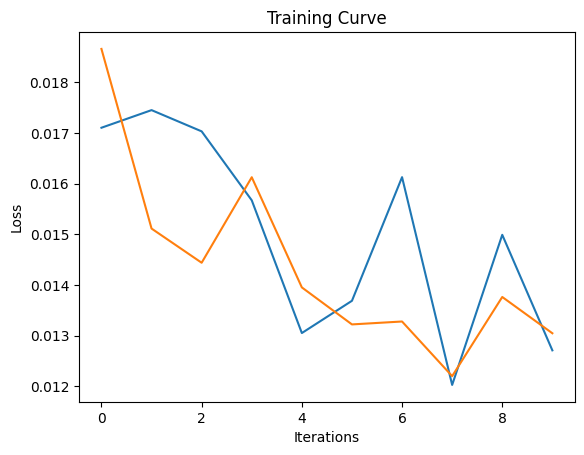

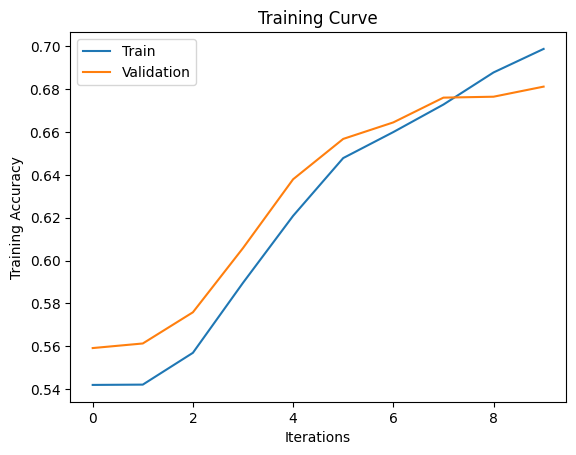

Final Training Accuracy: 0.6988433528487791
Final Validation Accuracy: 0.6812339331619537


In [67]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=64, lr=0.0001, num_epochs=10)

In [68]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=64, lr=0.0005, num_epochs=40)

Epoch 1: Train acc: 0.5956018849064687 | Validation acc: 0.6079691516709511
Epoch 2: Train acc: 0.6841353705554762 | Validation acc: 0.6782347900599829
Epoch 3: Train acc: 0.7138369270312723 | Validation acc: 0.6915167095115681
Epoch 4: Train acc: 0.7388262173354276 | Validation acc: 0.6966580976863753
Epoch 5: Train acc: 0.7718120805369127 | Validation acc: 0.7146529562982005
Epoch 6: Train acc: 0.7842353277166928 | Validation acc: 0.7039417309340189
Epoch 7: Train acc: 0.824646580037127 | Validation acc: 0.7176520994001714
Epoch 8: Train acc: 0.8440668285020705 | Validation acc: 0.7082262210796915


KeyboardInterrupt: 

Epoch 1: Train acc: 0.6091674996430101 | Validation acc: 0.6182519280205655
Epoch 2: Train acc: 0.682279023275739 | Validation acc: 0.6825192802056556
Epoch 3: Train acc: 0.7065543338569185 | Validation acc: 0.6885175664095973
Epoch 4: Train acc: 0.7425389118949022 | Validation acc: 0.7167952013710368
Epoch 5: Train acc: 0.7606739968584892 | Validation acc: 0.7253641816623821
Epoch 6: Train acc: 0.7788090818220762 | Validation acc: 0.7262210796915167
Epoch 7: Train acc: 0.8062259031843496 | Validation acc: 0.721936589545844
Epoch 8: Train acc: 0.8240753962587463 | Validation acc: 0.7133676092544987
Epoch 9: Train acc: 0.8487790946737113 | Validation acc: 0.7249357326478149
Epoch 10: Train acc: 0.8649150364129659 | Validation acc: 0.7146529562982005
Total time elapsed: 219.98 s


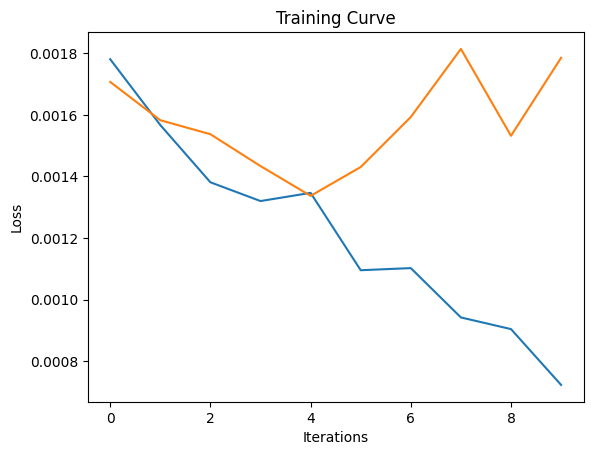

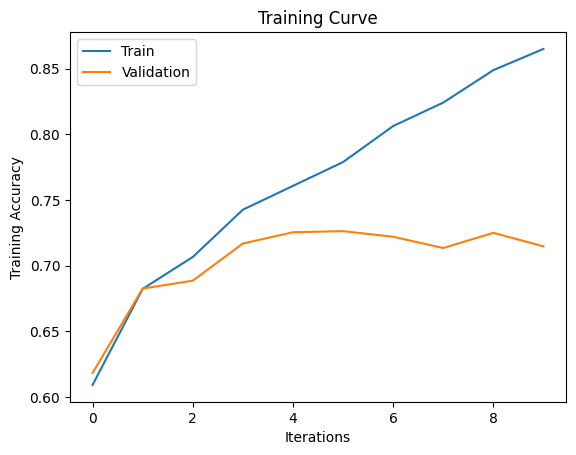

Final Training Accuracy: 0.8649150364129659
Final Validation Accuracy: 0.7146529562982005


In [69]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=512, lr=0.05, num_epochs=10)

Epoch 1: Train acc: 0.6704269598743395 | Validation acc: 0.6658097686375322
Epoch 2: Train acc: 0.7196915607596744 | Validation acc: 0.7146529562982005
Epoch 3: Train acc: 0.748107953734114 | Validation acc: 0.7253641816623821
Epoch 4: Train acc: 0.7613879765814651 | Validation acc: 0.715509854327335
Epoch 5: Train acc: 0.7936598600599742 | Validation acc: 0.7279348757497858
Epoch 6: Train acc: 0.7829501642153363 | Validation acc: 0.6940874035989717
Epoch 7: Train acc: 0.8287876624303869 | Validation acc: 0.709083119108826
Epoch 8: Train acc: 0.8494930743966871 | Validation acc: 0.7283633247643531
Epoch 9: Train acc: 0.8597743824075397 | Validation acc: 0.7240788346186804
Epoch 10: Train acc: 0.8676281593602742 | Validation acc: 0.7043701799485861
Total time elapsed: 183.86 s


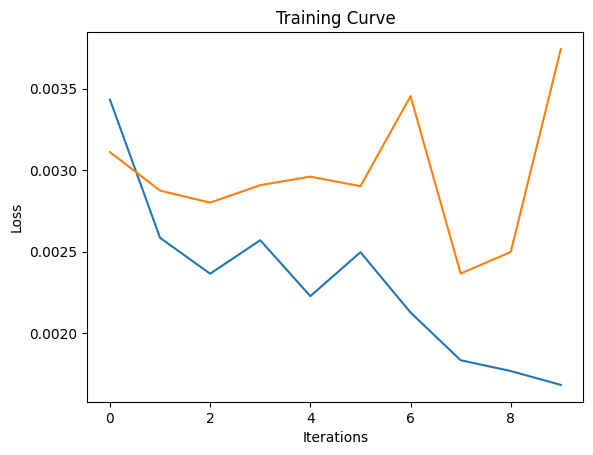

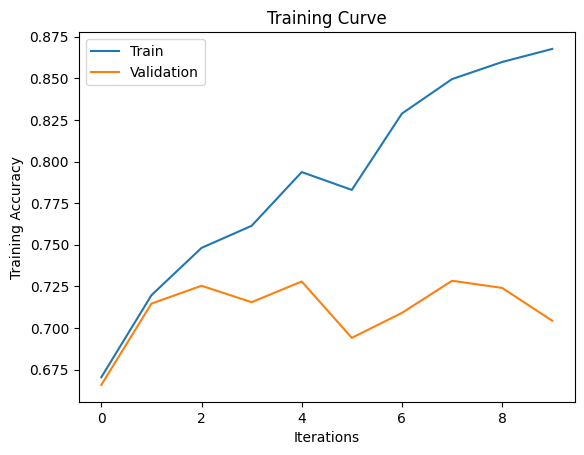

Final Training Accuracy: 0.8676281593602742
Final Validation Accuracy: 0.7043701799485861


In [70]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=256, lr=0.05, num_epochs=10)

Epoch 1: Train acc: 0.6150221333714122 | Validation acc: 0.6281062553556127
Epoch 2: Train acc: 0.6959874339568757 | Validation acc: 0.6936589545844044
Epoch 3: Train acc: 0.7175496215907469 | Validation acc: 0.6936589545844044
Epoch 4: Train acc: 0.7478223618449236 | Validation acc: 0.7206512425021423
Epoch 5: Train acc: 0.7849493074396687 | Validation acc: 0.7322193658954584
Epoch 6: Train acc: 0.8012280451235185 | Validation acc: 0.7125107112253641
Epoch 7: Train acc: 0.8349278880479795 | Validation acc: 0.718508997429306
Epoch 8: Train acc: 0.8409253177209767 | Validation acc: 0.7129391602399314
Epoch 9: Train acc: 0.8726260174211052 | Validation acc: 0.7142245072836333
Epoch 10: Train acc: 0.9008996144509496 | Validation acc: 0.715509854327335
Total time elapsed: 196.68 s


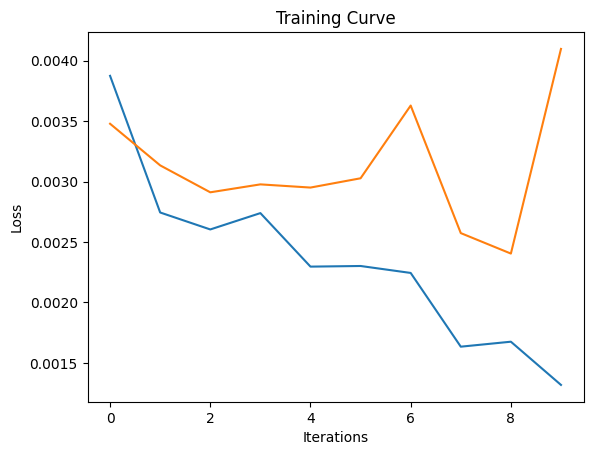

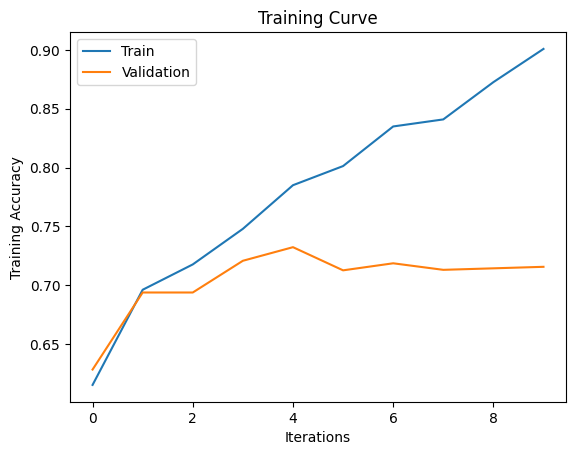

Final Training Accuracy: 0.9008996144509496
Final Validation Accuracy: 0.715509854327335


In [71]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=256, lr=0.005, num_epochs=10)

In [ ]:
model_cnn_3 = CNNClassifier() # 7000 training images
train(model_cnn_3, train_dataset, val_dataset, batch_size=128, lr=0.005, num_epochs=10)